Nama : Hendra Irawan,
Username : h9dra_irawan,
Email : h9dragstyle@gmail.com,
Kota Domisili : Kota Surabaya,
Tempat Lahir : Kota Tulungagung,
Tanggal Lahir : 09-05-2002,
Jenis Kelamin : Laki-laki,
Pendidikan Terakhir : SMA,
Pekerjaan/profesi Saat Ini : Pelajar/Mahasiswa,
Perusahaan/institusi Saat Ini : Institut Sains Terapan dan Teknologi Surabaya

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df = pd.read_csv('/content/drive/MyDrive/DICODING/warsaw.csv')
df

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNWD,TAVG,TMAX,TMIN
0,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,1993-01-01,0.0,10.0,-8.3,NaN,NaN
1,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,1993-01-02,NaN,10.0,-14.9,NaN,NaN
2,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,1993-01-03,0.0,10.0,-13.6,-9.7,NaN
3,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,1993-01-04,0.0,10.0,-10.5,-6.5,-13.3
4,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,1993-01-05,0.0,10.0,-12.0,-8.9,-14.1
...,...,...,...,...,...,...,...,...,...,...,...
10949,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,2022-12-27,8.4,NaN,4.7,9.4,2.7
10950,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,2022-12-28,0.0,NaN,3.3,NaN,NaN
10951,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,2022-12-29,0.5,NaN,6.8,NaN,3.7
10952,PLM00012375,"OKECIE, PL",52.166,20.967,110.3,2022-12-30,0.0,NaN,6.1,9.2,NaN


In [ ]:
df.isnull().sum()

STATION         0
NAME            0
LATITUDE        0
LONGITUDE       0
ELEVATION       0
DATE            0
PRCP         1796
SNWD         9531
TAVG            0
TMAX         3491
TMIN         5084
dtype: int64

In [4]:
dates = df['DATE'].values
temp  = df['TAVG'].values.reshape(-1, 1)

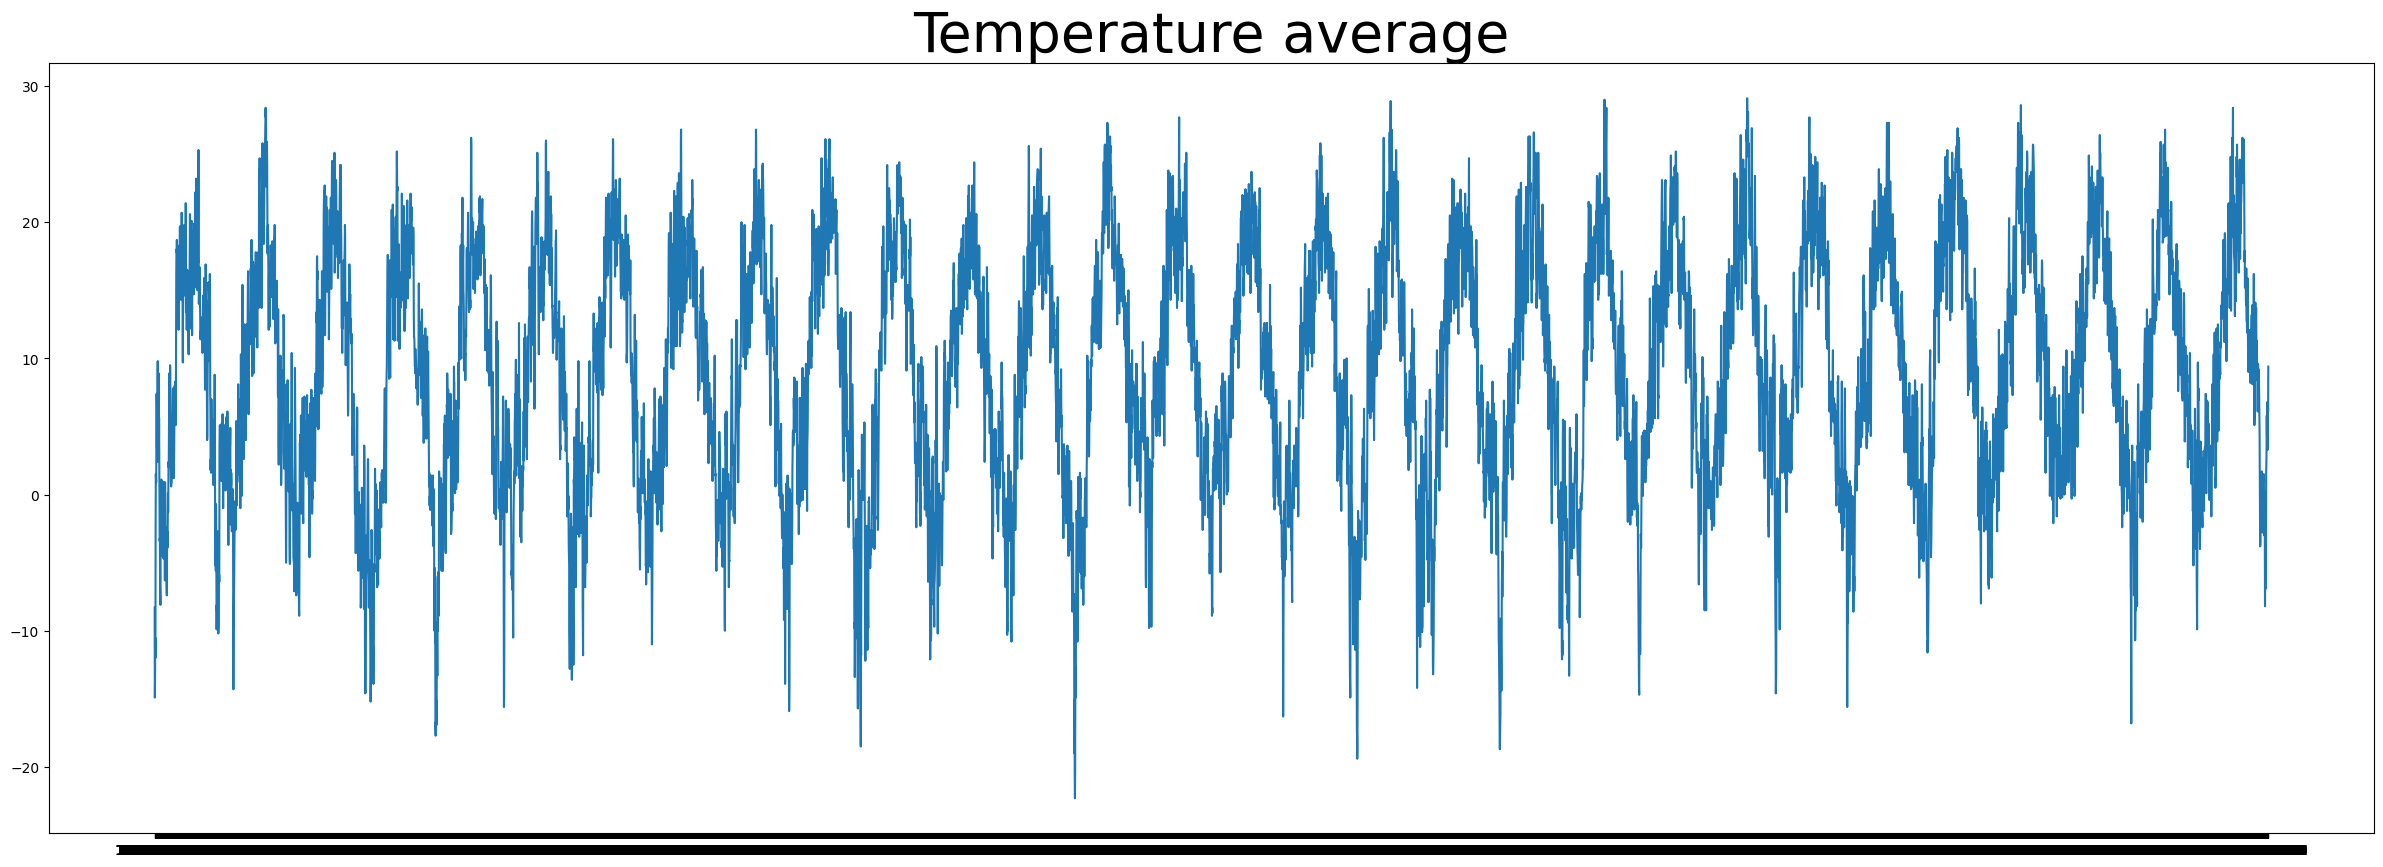

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(dates, temp)
plt.title('Temperature average',fontsize=40);

In [5]:
standard_scaler = StandardScaler()
temp = standard_scaler.fit_transform(temp).flatten()
threshold_mae = (temp.max() - temp.min()) * 10/100

In [21]:
print(threshold_mae)

0.5927988101605639


In [9]:
dates_train,dates_test,temp_train,temp_test = train_test_split(dates, temp, test_size=0.2,train_size=0.8,shuffle=False)

In [26]:
print(temp_train)
print(temp_train.size)

[-2.0083933  -2.76957465 -2.61964499 ... -0.62442721 -0.82048907
 -1.15494754]
8763


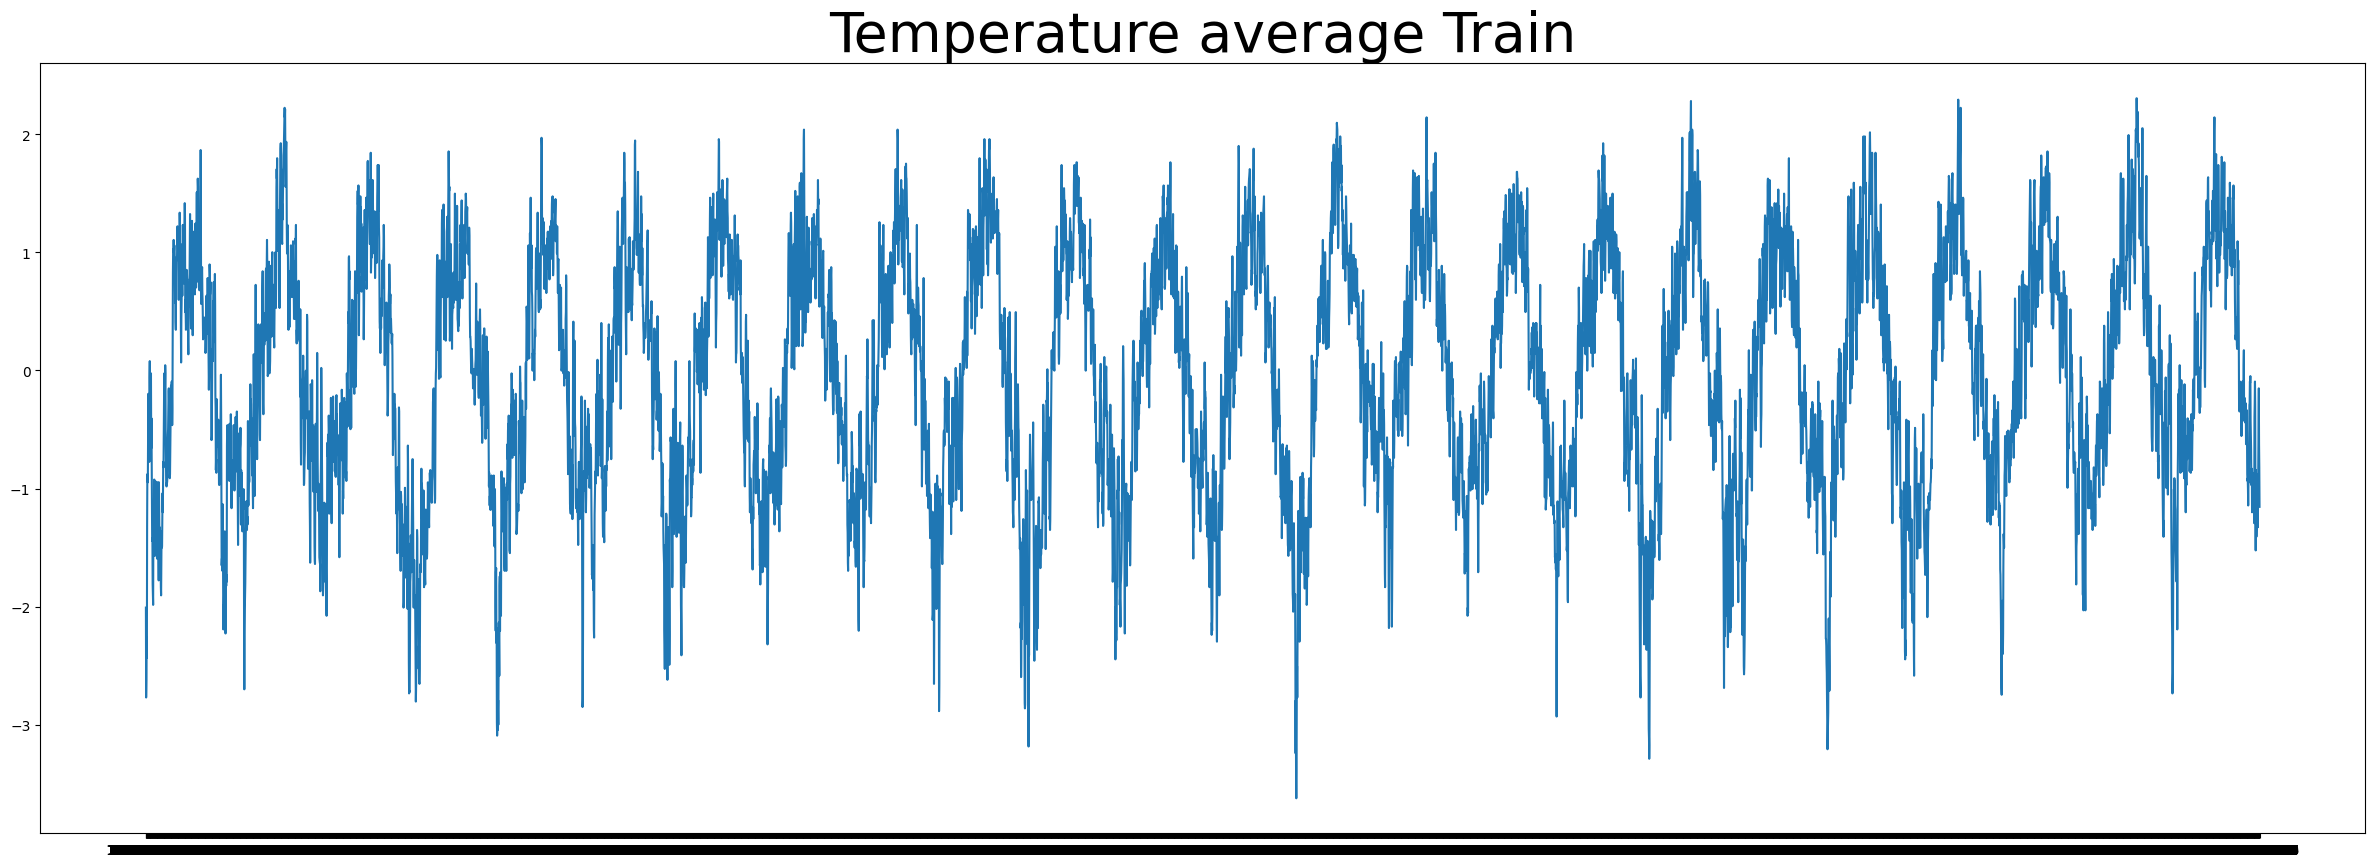

In [10]:
plt.figure(figsize=(30,10))
plt.plot(dates_train, temp_train)
plt.title('Temperature average Train',fontsize=40);

In [27]:
print(temp_test)
print(temp_test.size)

[-0.95888568 -0.98195178 -0.85508822 ... -0.26690263 -0.34763399
  0.03295669]
2191


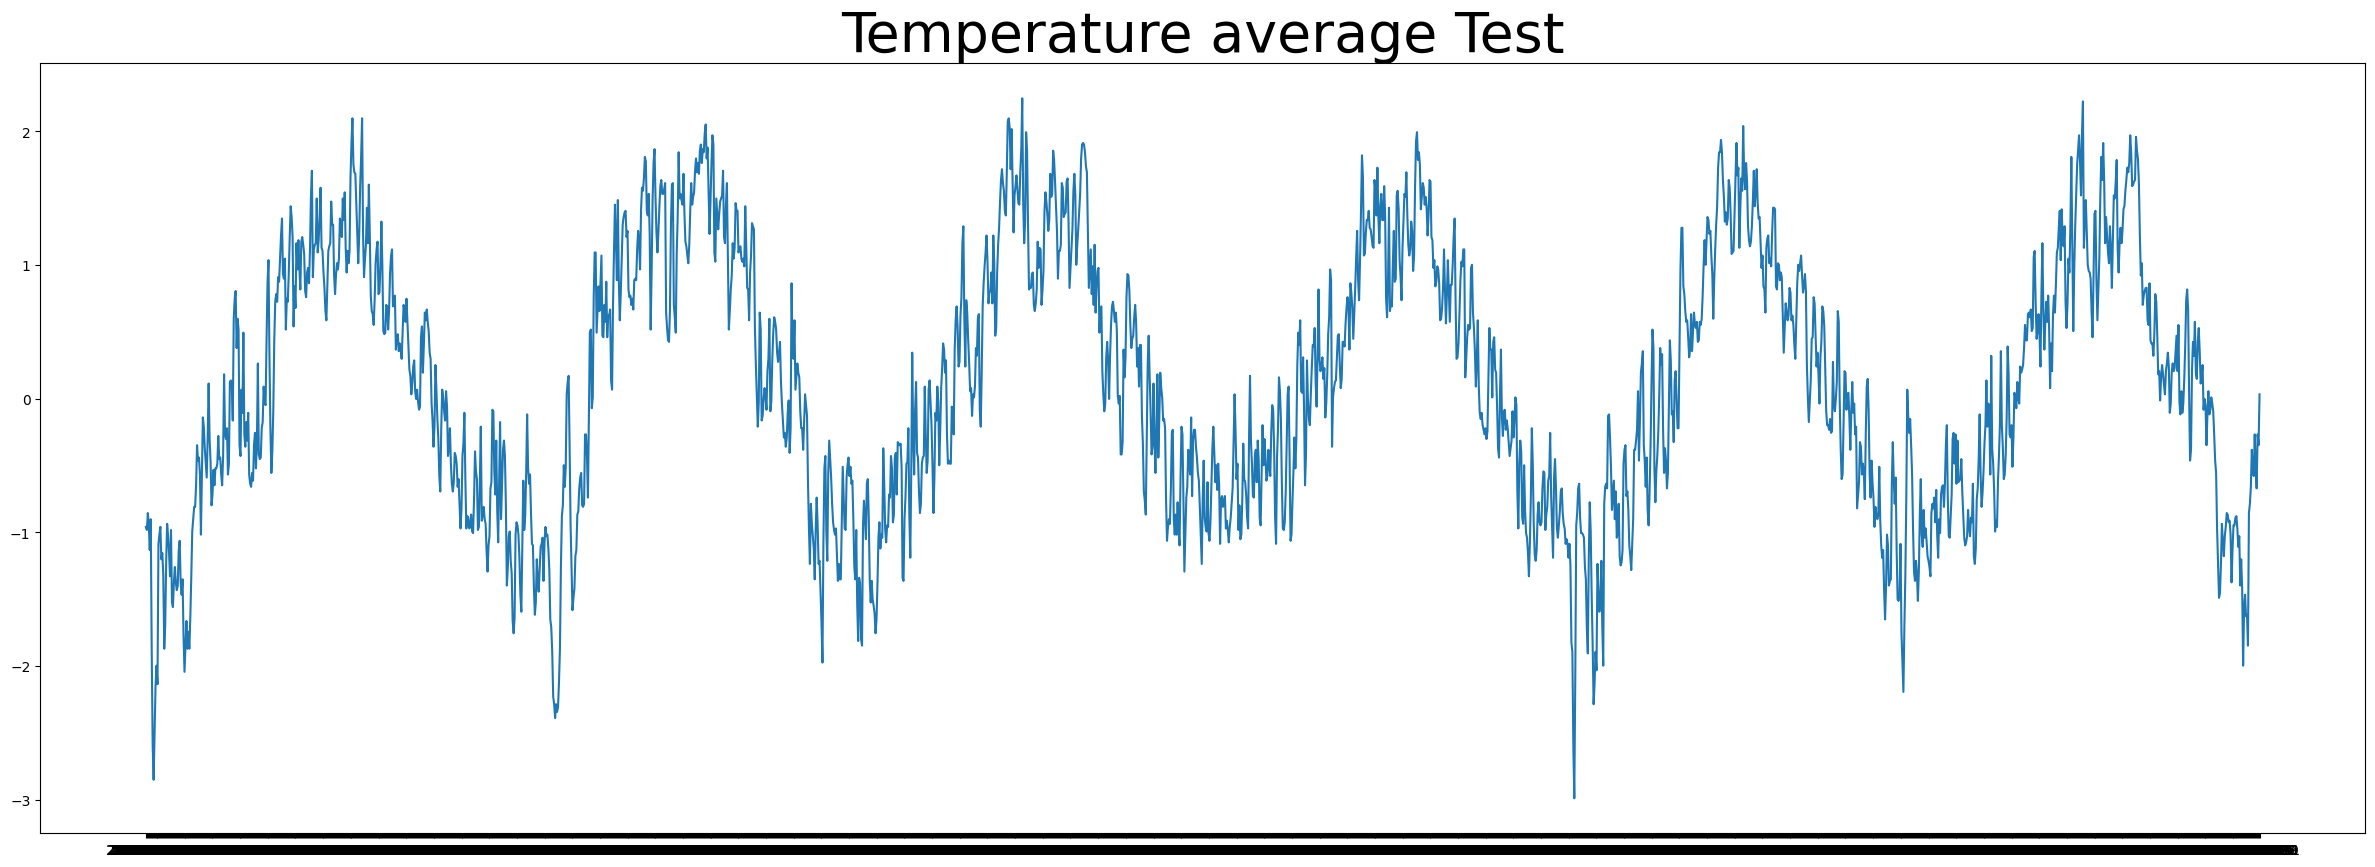

In [11]:
plt.figure(figsize=(30,10))
plt.plot(dates_test, temp_test)
plt.title('Temperature average Test',fontsize=40);

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae and epoch > 10):
      print("\n mae <10%!")
      self.model.stop_training = True
callbacks = myCallback()

In [16]:
train_set = windowed_dataset(temp_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(temp_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])
optimizer = tf.keras.optimizers.SGD(lr=0.1, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,
                    validation_data=test_set,
                    callbacks=[callbacks],
                    epochs=100,
                    verbose=1)

Epoch 1/100
88/88 [==============================] - 23s 195ms/step - loss: 0.1711 - mae: 0.4608 - val_loss: 0.0822 - val_mae: 0.3238
Epoch 2/100
88/88 [==============================] - 16s 171ms/step - loss: 0.0888 - mae: 0.3334 - val_loss: 0.0723 - val_mae: 0.3041
Epoch 3/100
88/88 [==============================] - 14s 156ms/step - loss: 0.0816 - mae: 0.3188 - val_loss: 0.0697 - val_mae: 0.2972
Epoch 4/100
88/88 [==============================] - 13s 140ms/step - loss: 0.0762 - mae: 0.3082 - val_loss: 0.0674 - val_mae: 0.2917
Epoch 5/100
88/88 [==============================] - 14s 158ms/step - loss: 0.0712 - mae: 0.2975 - val_loss: 0.0634 - val_mae: 0.2851
Epoch 6/100
88/88 [==============================] - 15s 169ms/step - loss: 0.0682 - mae: 0.2911 - val_loss: 0.0681 - val_mae: 0.2928
Epoch 7/100
88/88 [==============================] - 14s 158ms/step - loss: 0.0653 - mae: 0.2848 - val_loss: 0.0612 - val_mae: 0.2775
Epoch 8/100
88/88 [==============================] - 16s 170ms

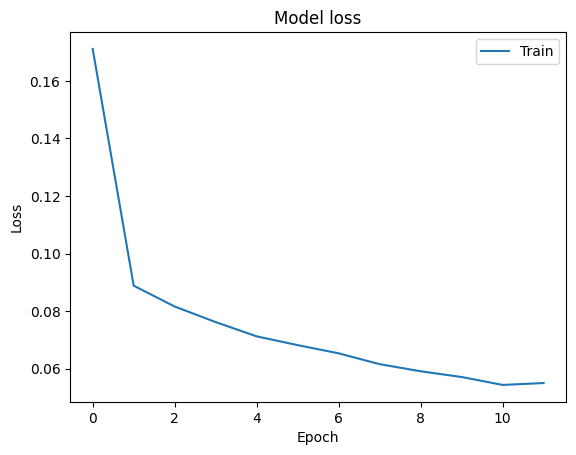

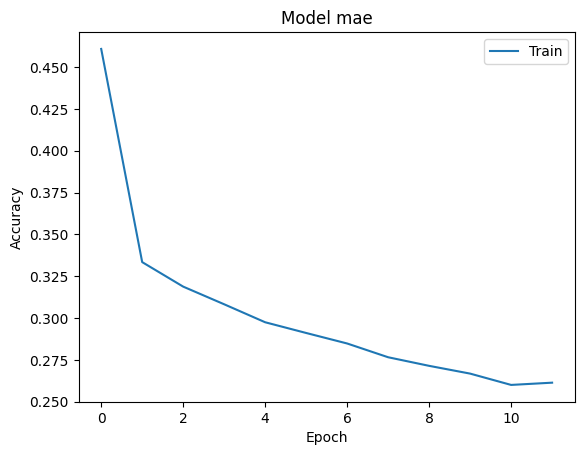

In [22]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()
plt.plot(history.history['mae'])
plt.title('Model mae')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

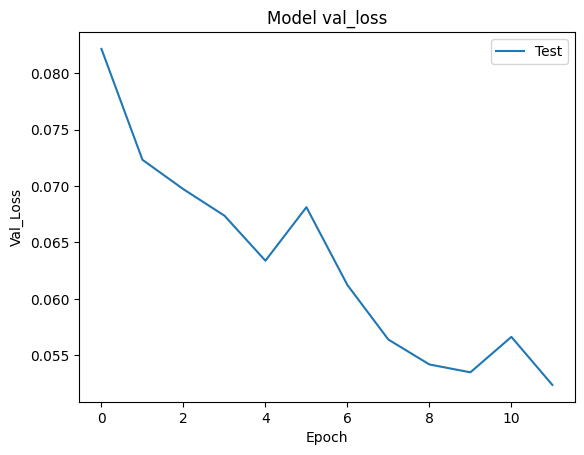

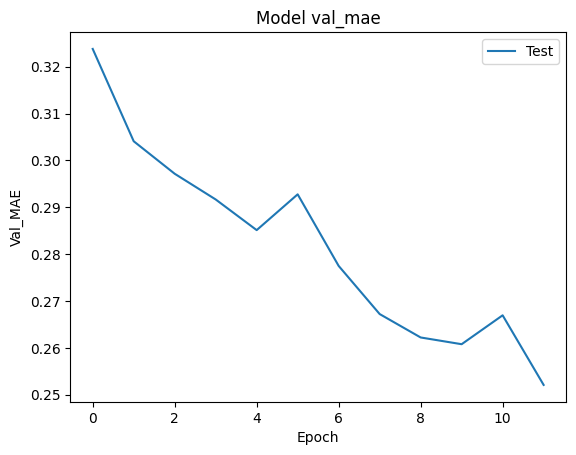

In [23]:
plt.plot(history.history['val_loss'])
plt.title('Model val_loss')
plt.ylabel('Val_Loss')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper right')
plt.show()
plt.plot(history.history['val_mae'])
plt.title('Model val_mae')
plt.ylabel('Val_MAE')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper right')
plt.show()